In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Load Data
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

df = pd.read_csv("Kasus_DBD_Gabungan.csv")
df.head()

,No,tahun,bulan,kode_provinsi,nama_provinsi,kode_kabupaten_kota,nama_kabupaten_kota,kasus_bulanan,total_tahunan,jumlah_curah_hujan,kepadatan_penduduk
0,1,2016,1,32,JAWA BARAT,3201,KABUPATEN BOGOR,245,3477,70.80,1546.0
1,2,2016,2,32,JAWA BARAT,3201,KABUPATEN BOGOR,267,3477,77.20,1546.0
2,3,2016,3,32,JAWA BARAT,3201,KABUPATEN BOGOR,281,3477,81.40,1546.0
3,4,2016,4,32,JAWA BARAT,3201,KABUPATEN BOGOR,261,3477,75.50,1546.0
4,5,2016,5,32,JAWA BARAT,3201,KABUPATEN BOGOR,269,3477,77.95,1546.0


In [3]:
# Preprocessing & Feature Engineering
num_cols = ['jumlah_curah_hujan','kepadatan_penduduk','kasus_bulanan','bulan','tahun']
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['kasus_bulanan']).copy()

if 'bulan' in df.columns:
    df['bulan'] = df['bulan'].astype('Int64')

df = df.sort_values(['kode_kabupaten_kota','tahun','bulan'])

df['rain_lag1'] = df.groupby('kode_kabupaten_kota')['jumlah_curah_hujan'].shift(1)
df['rain_3m_mean'] = df.groupby('kode_kabupaten_kota')['jumlah_curah_hujan'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)

df['rain_x_density'] = df['jumlah_curah_hujan'] * df['kepadatan_penduduk']

df['rain_lag1'] = df['rain_lag1'].fillna(df['jumlah_curah_hujan'])
df['rain_3m_mean'] = df['rain_3m_mean'].fillna(df['jumlah_curah_hujan'])

print("After feature engineering shape:", df.shape)

After feature engineering shape: (2916, 14)


In [4]:
# Feature Preparation
candidate_features = ['jumlah_curah_hujan','rain_lag1','rain_3m_mean','kepadatan_penduduk','rain_x_density','bulan']
available_features = [f for f in candidate_features if f in df.columns]
X = df[available_features].apply(pd.to_numeric, errors='coerce').astype(float)
X = X.fillna(X.median())
y = df['kasus_bulanan']

print("Available features:", available_features)

Available features: ['jumlah_curah_hujan', 'rain_lag1', 'rain_3m_mean', 'kepadatan_penduduk', 'rain_x_density', 'bulan']


In [5]:
# Feature Selection (Filter, Wrapper, Embedded)
# Filter Methods
mi = mutual_info_regression(X, y, random_state=0)
mi_series = pd.Series(mi, index=available_features).sort_values(ascending=False)

pearson_vals = {col: float(np.corrcoef(X[col], y)[0,1]) if X[col].var()!=0 else np.nan for col in available_features}
pearson = pd.Series(pearson_vals).sort_values(key=lambda s: s.abs(), ascending=False)

print("Mutual Information:\n", mi_series)
print("\nPearson Correlation:\n", pearson)

Mutual Information:
 kepadatan_penduduk    0.421149
rain_x_density        0.411692
jumlah_curah_hujan    0.331928
rain_3m_mean          0.239988
rain_lag1             0.205007
bulan                 0.039252
dtype: float64

Pearson Correlation:
 jumlah_curah_hujan    0.313818
rain_x_density        0.303129
rain_3m_mean          0.224104
kepadatan_penduduk    0.185226
rain_lag1             0.114214
bulan                -0.004189
dtype: float64


In [6]:
# Wrapper Method (RFE + RandomForest)
rfe_est = RandomForestRegressor(n_estimators=150, random_state=1)
rfe = RFE(estimator=rfe_est, n_features_to_select=min(3, len(available_features)))
rfe.fit(X, y)
rfe_ranking = pd.Series(rfe.ranking_, index=available_features).sort_values()
print("\nRFE Ranking (RF-based):\n", rfe_ranking)


RFE Ranking (RF-based):
 jumlah_curah_hujan    1
kepadatan_penduduk    1
rain_x_density        1
rain_3m_mean          2
rain_lag1             3
bulan                 4
dtype: int64


In [7]:
# Wrapper Method (RFE + LinearRegression)
lin_rfe = RFE(estimator=LinearRegression(), n_features_to_select=4)
lin_rfe.fit(X, y)

print("\nRFE (Linear Regression) support:", lin_rfe.support_)
print("RFE (Linear Regression) ranking:", lin_rfe.ranking_)

featureScore = pd.DataFrame({
    "Attr": X.columns,
    "Selected": lin_rfe.support_
})
print(featureScore)


RFE (Linear Regression) support: [ True  True  True False False  True]
RFE (Linear Regression) ranking: [1 1 1 2 3 1]
                 Attr  Selected
0  jumlah_curah_hujan      True
1           rain_lag1      True
2        rain_3m_mean      True
3  kepadatan_penduduk     False
4      rain_x_density     False
5               bulan      True


In [8]:
# Embedded Methods
lasso = LassoCV(cv=5, random_state=0, max_iter=5000).fit(X, y)
lasso_coefs = pd.Series(lasso.coef_, index=available_features).sort_values(key=lambda s: s.abs(), ascending=False)

ridge = Ridge(alpha=1.5)
ridge.fit(X, y)
ridge_coefs = pd.Series(ridge.coef_, index=available_features).sort_values(key=lambda s: s.abs(), ascending=False)

rf_full = RandomForestRegressor(n_estimators=250, random_state=2)
rf_full.fit(X, y)
rf_importances = pd.Series(rf_full.feature_importances_, index=available_features).sort_values(ascending=False)

print("\nLasso Coefficients:\n", lasso_coefs)
print("\nRidge Coefficients:\n", ridge_coefs)
print("\nRandomForest Importances:\n", rf_importances)


Lasso Coefficients:
 kepadatan_penduduk   -0.004683
rain_x_density        0.000147
rain_lag1             0.000000
jumlah_curah_hujan    0.000000
rain_3m_mean          0.000000
bulan                -0.000000
dtype: float64

Ridge Coefficients:
 jumlah_curah_hujan    0.684684
rain_3m_mean          0.336393
bulan                -0.329482
rain_lag1            -0.216697
kepadatan_penduduk   -0.001225
rain_x_density        0.000086
dtype: float64

RandomForest Importances:
 kepadatan_penduduk    0.636427
rain_x_density        0.172896
jumlah_curah_hujan    0.108692
rain_3m_mean          0.039323
rain_lag1             0.026474
bulan                 0.016189
dtype: float64


In [9]:
# Decision Tree Thresholds
dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=40, random_state=0)
dt.fit(X[['jumlah_curah_hujan', 'kepadatan_penduduk']], y)

tree_rules = export_text(dt, feature_names=['jumlah_curah_hujan','kepadatan_penduduk'])
print("Decision Tree Rules:\n", tree_rules)

# Extract thresholds
import re
thresholds = []
for line in tree_rules.splitlines():
    m = re.search(r'(.+?) <= ([0-9]*\.?[0-9]+)', line)
    if m: thresholds.append((m.group(1).strip(), float(m.group(2))))
    m2 = re.search(r'(.+?) > ([0-9]*\.?[0-9]+)', line)
    if m2: thresholds.append((m2.group(1).strip(), float(m2.group(2))))

rain_th = float(np.median([v for f,v in thresholds if 'hujan' in f or 'rain' in f.lower()]))
density_th = float(np.median([v for f,v in thresholds if 'kepadatan' in f.lower()]))

print('\nSelected thresholds:')
print('rain_th =', rain_th)
print('density_th =', density_th)

df['rain_exceed'] = (df['jumlah_curah_hujan'] > rain_th).astype(int)
df['density_exceed'] = (df['kepadatan_penduduk'] > density_th).astype(int)
df['combined_risk'] = df['rain_exceed'] + df['density_exceed']

Decision Tree Rules:
 |--- kepadatan_penduduk <= 14288.50
|   |--- kepadatan_penduduk <= 201.28
|   |   |--- kepadatan_penduduk <= 9.55
|   |   |   |--- value: [171.11]
|   |   |--- kepadatan_penduduk >  9.55
|   |   |   |--- value: [347.60]
|   |--- kepadatan_penduduk >  201.28
|   |   |--- jumlah_curah_hujan <= 55.26
|   |   |   |--- value: [28.20]
|   |   |--- jumlah_curah_hujan >  55.26
|   |   |   |--- value: [84.61]
|--- kepadatan_penduduk >  14288.50
|   |--- jumlah_curah_hujan <= 70.27
|   |   |--- value: [189.26]
|   |--- jumlah_curah_hujan >  70.27
|   |   |--- value: [392.86]


Selected thresholds:
rain_th = 62.765
density_th = 201.28


In [10]:
# Model Evaluation (RF + Linear Regression)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# RandomForest
rf_eval = RandomForestRegressor(n_estimators=200, random_state=5)
rf_eval.fit(X_train, y_train)
pred_rf = rf_eval.predict(X_test)

print("\nRandomForest MSE:", mean_squared_error(y_test, pred_rf))
print("RandomForest R2:", r2_score(y_test, pred_rf))

# Linear Regression
lin = LinearRegression()
lin.fit(X_train, y_train)
pred_lin = lin.predict(X_test)

print("\nLinear Regression MSE:", mean_squared_error(y_test, pred_lin))
print("Linear Regression R2:", r2_score(y_test, pred_lin))


RandomForest MSE: 2298.880054965753
RandomForest R2: 0.8096642883948781

Linear Regression MSE: 10492.425313433734
Linear Regression R2: 0.13127993164229967


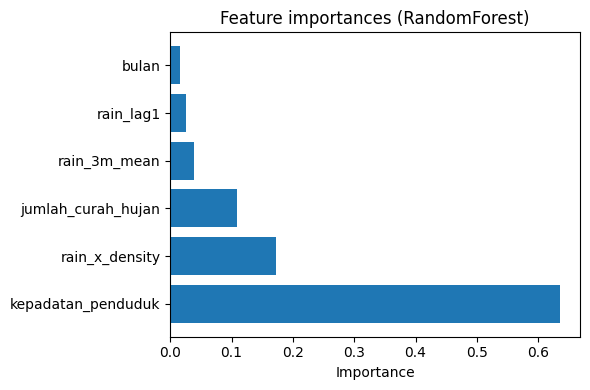

In [11]:
# VISUALIZATION
# 1) RF Feature importance plot
imp = rf_importances.sort_values(key=lambda s: s.abs(), ascending=False)
plt.figure(figsize=(6,4))
plt.barh(imp.index.astype(str), imp.values)
plt.title('Feature importances (RandomForest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

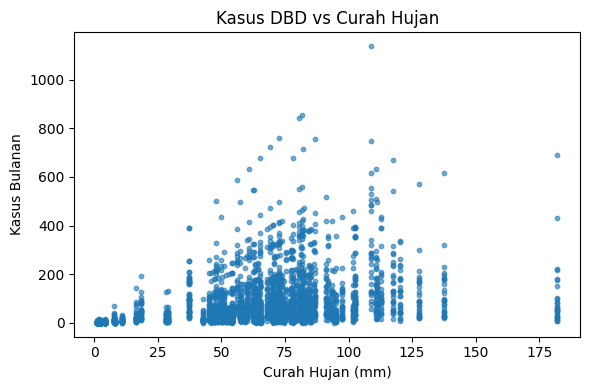

In [12]:
# 2) Scatter rainfall vs cases
plt.figure(figsize=(6,4))
plt.scatter(df['jumlah_curah_hujan'], df['kasus_bulanan'], s=10, alpha=0.6)
plt.xlabel("Curah Hujan (mm)")
plt.ylabel("Kasus Bulanan")
plt.title("Kasus DBD vs Curah Hujan")
plt.tight_layout()
plt.show()

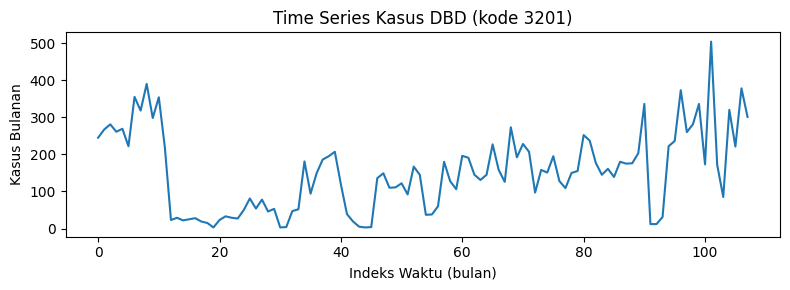

In [13]:
# 3) Time series example
grouped = df.groupby('kode_kabupaten_kota').size().sort_values(ascending=False)
sample_kode = grouped.index[0]
sample_df = df[df['kode_kabupaten_kota']==sample_kode].sort_values(['tahun','bulan'])

plt.figure(figsize=(8,3))
plt.plot(sample_df['kasus_bulanan'].values)
plt.title(f"Time Series Kasus DBD (kode {sample_kode})")
plt.ylabel("Kasus Bulanan")
plt.xlabel("Indeks Waktu (bulan)")
plt.tight_layout()
plt.show()